In [4]:
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy
from surprise import Dataset, Reader
from surprise.dump import dump

from recmetrics import rmse, mse, mark, mark_plot

from os.path import join, split
from random import sample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [5]:
_HERE = ''
dataset_path = join(_HERE, '..', '..', 'dataset', 'movielens', 'ratings.csv')
dataset_path

'../../dataset/movielens/ratings.csv'

# Read dataset

In [6]:
ratings = pd.read_csv(dataset_path)
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


# k-NN Model training

In [7]:
reader = Reader(line_format='user item rating timestamp', sep=',' , rating_scale=(0.5, 5), skip_lines=162541*150)
data = Dataset.load_from_file(dataset_path, reader=reader)
trainset, testset = train_test_split(data, test_size=.25)

In [8]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(k=2, sim_options=sim_options, verbose=True)

In [9]:
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [10]:
preds = algo.test(testset, verbose=False)

In [11]:
preds = pd.DataFrame(preds)
preds.drop("details", inplace=True, axis=1)
preds.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
preds.head()

,userId,movieId,actual,cf_predictions
0,158753,3535,4.0,2.5
1,162052,96821,4.0,4.5
2,160922,4091,3.5,3.5
3,159504,3147,3.5,4.0
4,162416,1190,2.5,2.0


# Recommendations

In [12]:
cf_model = preds.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)
cf_model.head()

movieId,1,10,100,100034,100044,100060,100083,100106,100108,100150,...,998,999,99910,99912,99915,99917,99957,99968,99992,99996
userId,,,,,,,,,,,,,,,,,,,,,
158413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158417,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
test = preds.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})
test = test.set_index("userId")
test.head()

,actual
userId,
158413,"[2616, 1965, 1729, 2993, 3819, 1580, 8368, 236..."
158414,"[141, 3005, 2762, 1569, 1407, 830, 2706, 2605,..."
158415,"[5459, 60]"
158416,"[1466, 2918, 1097, 1729, 3363, 1721]"
158417,"[150, 1270, 44665, 1580, 21, 1196, 6857, 47200..."


# k-NN recommendations

In [14]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [15]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in tqdm(test.index, desc='k-NN recommendations', total=len(test.index)):
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

k-NN recommendations: 100%|██████████| 4129/4129 [00:09<00:00, 429.62it/s]


,actual,cf_predictions
userId,,
158413,"[2616, 1965, 1729, 2993, 3819, 1580, 8368, 236...","[3360, 2987, 2692, 3735, 5299, 2677, 3947, 285..."
158414,"[141, 3005, 2762, 1569, 1407, 830, 2706, 2605,...","[4969, 356, 8665, 4993, 2605, 141, 3176, 3005,..."
158415,"[5459, 60]","[5459, 60, 1, 55288, 55274, 55276, 55278, 5528..."
158416,"[1466, 2918, 1097, 1729, 3363, 1721]","[2918, 1097, 1466, 3363, 1721, 1729, 55292, 55..."
158417,"[150, 1270, 44665, 1580, 21, 1196, 6857, 47200...","[27618, 6857, 1580, 3635, 1036, 788, 47200, 46..."


# Popularity-based recommendations

In [16]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in tqdm(test.index, desc='Popularity-based recommendations', total=len(test.index)):
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

Popularity-based recommendations: 100%|██████████| 4129/4129 [00:00<00:00, 758243.49it/s]


,actual,cf_predictions,pop_predictions
userId,,,
158413,"[2616, 1965, 1729, 2993, 3819, 1580, 8368, 236...","[3360, 2987, 2692, 3735, 5299, 2677, 3947, 285...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158414,"[141, 3005, 2762, 1569, 1407, 830, 2706, 2605,...","[4969, 356, 8665, 4993, 2605, 141, 3176, 3005,...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158415,"[5459, 60]","[5459, 60, 1, 55288, 55274, 55276, 55278, 5528...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158416,"[1466, 2918, 1097, 1729, 3363, 1721]","[2918, 1097, 1466, 3363, 1721, 1729, 55292, 55...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."
158417,"[150, 1270, 44665, 1580, 21, 1196, 6857, 47200...","[27618, 6857, 1580, 3635, 1036, 788, 47200, 46...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959..."


# Random recommendations

In [18]:
# make recommendations for all members in the test data

ran_recs = []
movies = ratings.movieId.values.tolist()

for user in tqdm(test.index, desc='Random recommendations', total=len(test.index)):
    random_predictions = sample(movies, 10)
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

Random recommendations: 100%|██████████| 4129/4129 [00:00<00:00, 16031.69it/s]


,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
158413,"[2616, 1965, 1729, 2993, 3819, 1580, 8368, 236...","[3360, 2987, 2692, 3735, 5299, 2677, 3947, 285...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[539, 8957, 8644, 1476, 5378, 720, 3968, 1517,..."
158414,"[141, 3005, 2762, 1569, 1407, 830, 2706, 2605,...","[4969, 356, 8665, 4993, 2605, 141, 3176, 3005,...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[80939, 356, 73023, 1210, 30846, 1014, 7112, 4..."
158415,"[5459, 60]","[5459, 60, 1, 55288, 55274, 55276, 55278, 5528...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[68954, 592, 68358, 1241, 1207, 47, 86332, 497..."
158416,"[1466, 2918, 1097, 1729, 3363, 1721]","[2918, 1097, 1466, 3363, 1721, 1729, 55292, 55...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[380, 898, 59126, 44555, 4718, 1378, 54272, 71..."
158417,"[150, 1270, 44665, 1580, 21, 1196, 6857, 47200...","[27618, 6857, 1580, 3635, 1036, 788, 47200, 46...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[6952, 3897, 160289, 357, 48780, 3477, 56367, ..."


# Model Evaluation

In [19]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [20]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [22]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.0807992121592752,
 0.16014528796592264,
 0.23610071228310536,
 0.3060821315950406,
 0.3680713009675232,
 0.4221166582789741,
 0.46966326690228416,
 0.5110513452692195,
 0.5469296149657746,
 0.5783946557395342]

In [23]:
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
158413,"[2616, 1965, 1729, 2993, 3819, 1580, 8368, 236...","[3360, 2987, 2692, 3735, 5299, 2677, 3947, 285...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[539, 8957, 8644, 1476, 5378, 720, 3968, 1517,..."
158414,"[141, 3005, 2762, 1569, 1407, 830, 2706, 2605,...","[4969, 356, 8665, 4993, 2605, 141, 3176, 3005,...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[80939, 356, 73023, 1210, 30846, 1014, 7112, 4..."
158415,"[5459, 60]","[5459, 60, 1, 55288, 55274, 55276, 55278, 5528...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[68954, 592, 68358, 1241, 1207, 47, 86332, 497..."
158416,"[1466, 2918, 1097, 1729, 3363, 1721]","[2918, 1097, 1466, 3363, 1721, 1729, 55292, 55...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[380, 898, 59126, 44555, 4718, 1378, 54272, 71..."
158417,"[150, 1270, 44665, 1580, 21, 1196, 6857, 47200...","[27618, 6857, 1580, 3635, 1036, 788, 47200, 46...","[318, 356, 296, 593, 2571, 260, 527, 480, 2959...","[6952, 3897, 160289, 357, 48780, 3477, 56367, ..."


In [24]:
print("MSE: ", mse(preds.actual, preds.cf_predictions))
print("RMSE: ", rmse(preds.actual, preds.cf_predictions))

MSE:  1.4481031863349245
RMSE:  1.2033715911284113


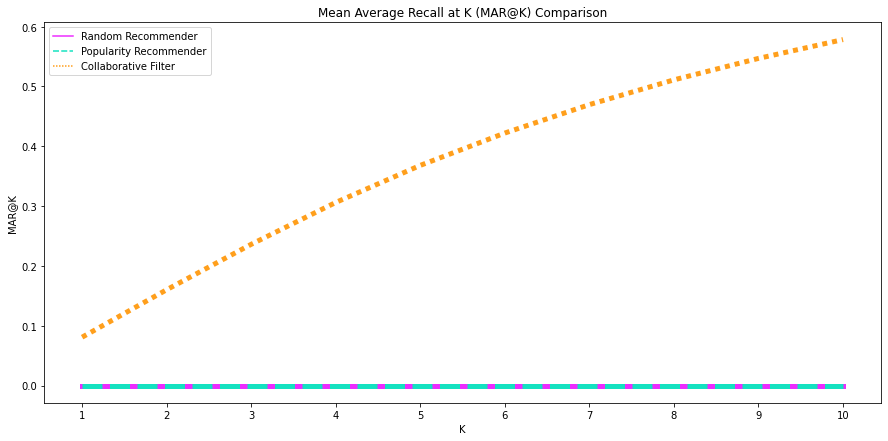

In [25]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,11)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

# Saving predictions & model

In [26]:
dumping_path = join(_HERE, '..', '..', 'artifacts', 'k-nn.dump')
dump(dumping_path, algo=algo, verbose=1)

The dump has been saved as file ../../artifacts/k-nn.dump
